# Principal Component Analysis

## Introduction

In this exercise, you will experiment with two different techniques to compute the principal components of a dataset:

* **Basic PCA**: The standard technique based on singular value decomposition.


* **Iterative PCA**: A technique that progressively optimizes the PCA objective function.

Principal component analysis is applied here to modeling handwritten characters data (characters "O" and "I") using the dataset introduced in the paper "L.J.P. van der Maaten. 2009. A New Benchmark Dataset for Handwritten Character Recognition". The dataset consists of black and white images of $28 \times 28$ pixels, each representing a handwritten character. For the purpose of the PCA analysis, these images are interpreted as 784-dimensional vectors with values between 0 and 1. Three methods are provided for your convenience and are available in the module `utils` that is included in the zip archive. The methods are the following:

* **`utils.load()`** load data from the file `characters.csv` and stores them in a data matrix of size $4631 \times 784$. (The data is a subset of the original dataset available here: http://lvdmaaten.github.io/publications/misc/characters.zip)


* **`utils.scatterplot(...)`** produces a scatter plot from a two-dimensional data set. Each point in the scatter plot represents one handwritten character. This method provides a convenient way to produce two-dimensional PCA plots.


* **`utils.render(...)`** takes a matrix of size $n \times 784$ as input, interprets it as $n$ images of size $28 \times 28$, and renders these images in the IPython notebook.

A demo code that makes use of these methods is given below. It performs basic data analysis, for example, plotting simple statistics for each data point in the dataset, or rendering a few examples randomly selected from the dataset.

dataset size: (4631, 784)


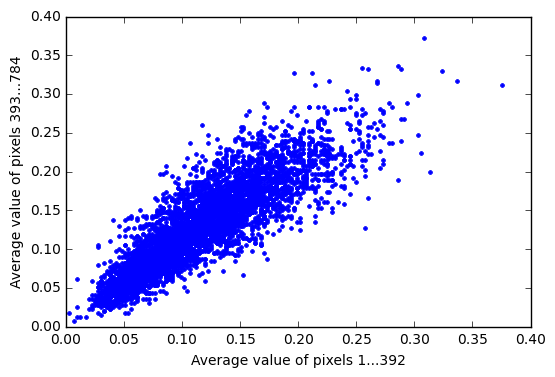

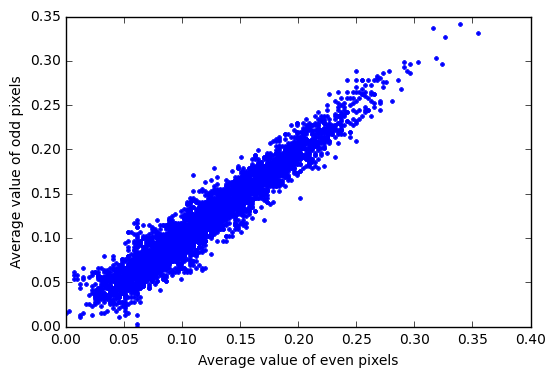

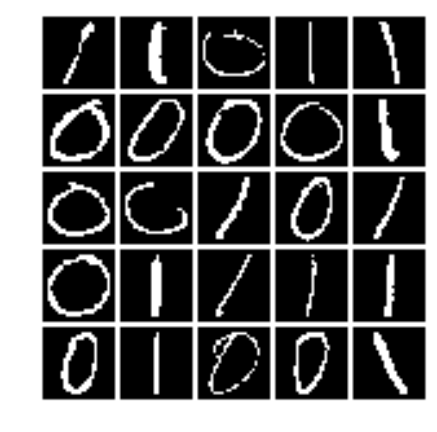

In [156]:
import utils,numpy
%matplotlib inline

# Load the characters "O" and "I" from the handwritten characters dataset
X = utils.load()

print('dataset size: %s'%str(X.shape))

# Plot some statistics of the data using the scatterplot function
utils.scatterplot(X[:,:392].mean(axis=1),X[:,392:].mean(axis=1),
                  xlabel='Average value of pixels 1...392',
                  ylabel='Average value of pixels 393...784')
utils.scatterplot(X[:,::2].mean(axis=1),X[:,1::2].mean(axis=1),
                  xlabel='Average value of even pixels',
                  ylabel='Average value of odd pixels')

# Render some randomly selected examples
R=numpy.random.randint(0,len(X),[25])
utils.render(X[R])

The preliminary data analysis above does not reveal particularly interesting structure in the data. For example scatter plots fail to let appear the two types of characters present in the dataset ("O" and "I"). Therefore, we would like to gain more insight on the dataset by performing a more sophisticated analysis based on PCA.

## PCA with Singular Value Decomposition (15 P)

As shown during the lecture, principal components can be found by solving the eigenvalue problem

$$
\boldsymbol{S} \boldsymbol{w} = \lambda \boldsymbol{w}.
$$

While we could eigendecompose the scatter matrix to find the desired eigenvalues and eigenvectors (for example, by using the function `numpy.linalg.eigh`), we usually prefer to recover principal components directly from singular value decomposition

$$
\boldsymbol{X} = \boldsymbol{U} \, \boldsymbol{\Sigma} \, \boldsymbol{V}^\top,
$$

where the principal components and projection of data onto these components can also be retrieved from the matrices $\boldsymbol{U}$, $\boldsymbol{\Sigma}$ and $\boldsymbol{V}$.

**Tasks:**

* **Compute the principal components of the data using the function `numpy.linalg.svd`.**
* **Measure the computational time required to find the principal components. Use the function `time.time()` for that purpose. Do *not* include in your estimate the computation overhead caused by loading the data, plotting and rendering.**
* **Plot the projection of the dataset on the first two principal components using the function `utils.scatterplot`.**
* **Visualize the 25 leading principal components using the function `utils.render`.**

Note that if the algorithm runs for more than 1 minute, you might be doing something wrong.

In [157]:
import time
import numpy as np

X = utils.load()

col_means = X.mean(axis=1)
col_sds = X.std(axis=1)
X = X - col_means[:,np.newaxis]
#X = X / col_sds[:,np.newaxis]

start = time.time()
U, s, Vt = np.linalg.svd(X, full_matrices = 0)
print('Time: {0:.4f} seconds'.format(time.time() - start))

V = Vt.T
S = np.diag(s)
# PCs are already sorted by descending order 
# of the singular values (i.e. by the
# proportion of total variance they explain)

Time: 2.6629 seconds


Using all PCs:
	- MSE = 1.039E-14
	- Rel. var. expl. = 1.0000
Using first 20 PCs
	- MSE = 0.03862
	- Rel. var. expl. = 0.2049
Using first 2 PCs
	- MSE = 0.07279
	- Rel. var. expl. = 0.0510


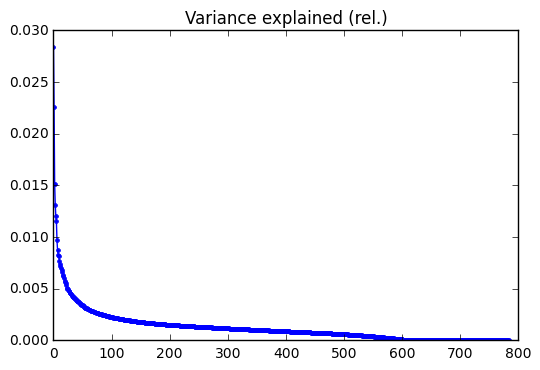

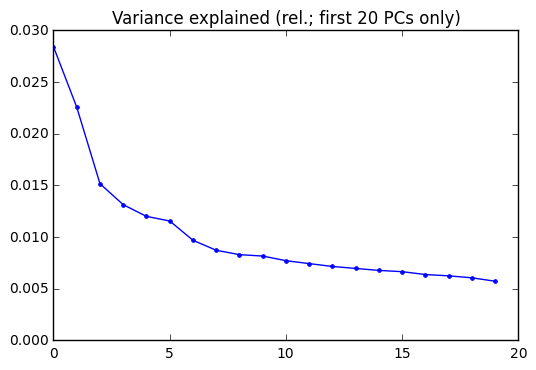

In [158]:
# if we use all of the PCs we can reconstruct the noisy signal perfectly
Xhat = np.dot(U, np.dot(S, V.T))
print("Using all PCs:\n\t- MSE = {0:.4G}\n\t- Rel. var. expl. = {1:.4f}".format(np.mean((X - Xhat)**2), s[:].sum() / s.sum()))

# if we use only the first 20 PCs the reconstruction is less accurate
Xhat20 = np.dot(U[:, :20], np.dot(S[:20, :20], V[:,:20].T))
print("Using first 20 PCs\n\t- MSE = {0:.4G}\n\t- Rel. var. expl. = {1:.4f}".format(np.mean((X - Xhat20)**2), s[:20].sum() / s.sum()))

# now only 2
Xhat2 = np.dot(U[:, :2], np.dot(S[:2, :2], V[:,:2].T))
print("Using first 2 PCs\n\t- MSE = {0:.4G}\n\t- Rel. var. expl. = {1:.4f}".format(np.mean((X - Xhat2)**2), s[:2].sum() / s.sum()))

plt.plot(s/s.sum(), marker='.')
plt.title("Variance explained (rel.)")
plt.show()

plt.plot(s[:20]/s.sum(), marker='.')
plt.ylim([0,.03])
plt.title("Variance explained (rel.; first 20 PCs only)")
plt.show()


twoPC.shape: (2, 784) 
Y.shape: (4631, 2)


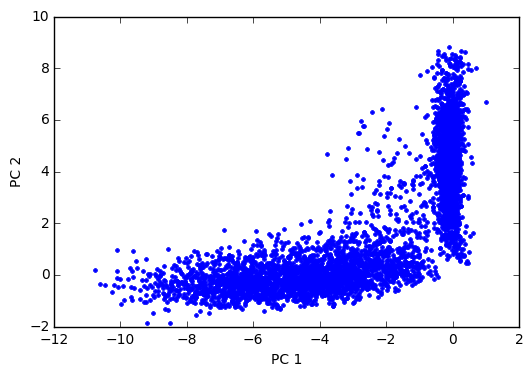

In [159]:
# strip first two principle components
twoPC = Vt[:2,:]

# Y is going to be our projection
Y = np.zeros((len(X), twoPC.shape[0]))

# compute projection
for i in range(Y.shape[0]):
    Y[i,:] = twoPC.dot(X[i])

print("twoPC.shape:", twoPC.shape, "\nY.shape:", Y.shape)
    
# render projections with scatterplot
utils.scatterplot(Y[:,0],Y[:,1],xlabel='PC 1',ylabel='PC 2')

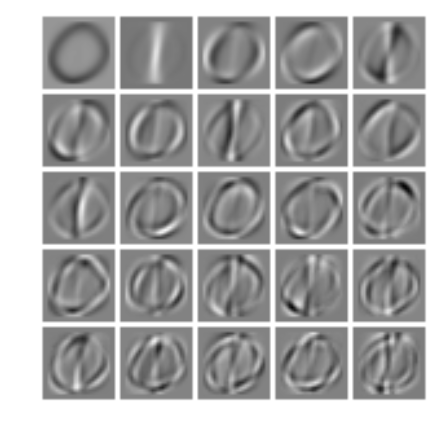

In [160]:
utils.render(Vt[:25,:])

## Iterative PCA (15 P)

The objective that PCA optimizes is given by

$$
J(\boldsymbol{w}) = \boldsymbol{w}^\top \boldsymbol{S} \boldsymbol{w}
$$

subject to

$$
\boldsymbol{w}^\top \boldsymbol{w} = 1.
$$

The power iteration algorithm maximizes this objective using an iterative procedure. It starts with an initial weight vector $\boldsymbol{w}$, and iteratively applies the update rule

$$
\boldsymbol{w} \leftarrow \frac{\boldsymbol{S} \boldsymbol{w}}{\|\boldsymbol{S} \boldsymbol{w}\|}
$$

**Tasks:**

* **Implement the iterative procedure. Use as a stopping criterion the value of $J(\boldsymbol{w})$ between two iterations increasing by less than $0.01$.**
* **Print the value of the objective function $J(\boldsymbol{w})$ at each iteration.**
* **Measure the time taken to find the principal component.**
* **Visualize the the eigenvector $\boldsymbol{w}$ obtained after convergence using the function `utils.render`.**

Note that if the algorithm runs for more than 1 minute, you might be doing something wrong.

iteration 0	J(w) = 128495.150
iteration 1	J(w) = 128923.389
iteration 2	J(w) = 128970.809
iteration 3	J(w) = 128977.005
iteration 4	J(w) = 128977.820
iteration 5	J(w) = 128977.928
iteration 6	J(w) = 128977.942
iteration 7	J(w) = 128977.944
Stopping criterion satisfied.
Time: 0.1201 seconds


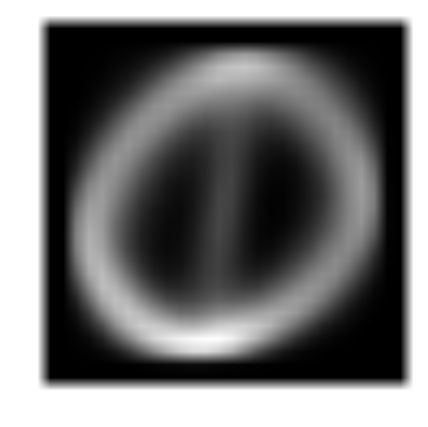

In [161]:
import utils,time
import numpy as np
%matplotlib inline

# Load the characters "O" and "I" from the handwritten characters dataset
X = utils.load()

# S is out scatter matrix
S = np.dot(X.T, X)

# create random initialization vector
w = np.random.rand(S.shape[0], 1)
# normalize initialization vector
w = np.divide(w, np.linalg.norm(w))

i = 0
# epsilon contains the threshold value for stopping the power iteration
eps = 0.01
# norm is the eigenvalue from step k
norm = 1.
# last contains the eigenvalue from step k-1
last = 0.

start = time.time()
while abs(last - norm) > eps:
        # do power iteration step
        last = norm
        w = np.dot(S, w)
        norm = np.linalg.norm(w)
        w = np.divide(w, norm)
        # print value of objective function
        print("iteration {0}\tJ(w) = {1:.3f}".format(i, np.asscalar(np.dot(np.dot(w.T, S), w))))
        i += 1
print('Stopping criterion satisfied.\nTime: {0:.4f} seconds'.format(time.time() - start))

# render the principle component obtained via power iteration
utils.render(w.T)